# Selection of a region for oil production using linear regression and bootstrap

# Project goal:

In this project I explore 3 oil producing regions, predict the best oil fields in these regions using linear regression, and evaluate possible profits and risks of developing these fields using the Bootstrap technique.

# Project planning

- Understand nature of the data, analyze .info() .describe() and check correlations between features
- Prepare the data. Check it for missing values, change data types if necessary, etc. Split the data into train/validation datasets
- Train an ML model. In this project, linear regression is used to predict the amount of oil in an oil field.
- Use the ML model to predict the amount of oil. Calculate the profits the company would make if it developed the oil fields predicted by the model.
- Use the Bootstrap technique to estimate mean profit, 95% confidence interval and the risks of loss (loss is defined as negative profit from oil field development)
- Compare results. Provide recommendations to an oil company based on this research. 

# Task description

- Only linear regression is suitable for training the model (other models are considered to be not predictable enough).
- During the exploration of the region, 500 filds are explored, from which, using machine learning, the best 200 are selected for development.
- The budget for the development of wells in the region is 10 billion rubles.
- One barrel of raw materials brings 450 rubles of income. The income from each unit of the product is 450 thousand rubles, since the volume is indicated in thousands of barrels.
- The data is synthetic: details of contracts and characteristics of the oil fields are not disclosed.

# Data description

Data about the regions is located in the datasets below:

- /geo_data_0.csv
- /geo_data_1.csv
- /geo_data_2.csv


- id — id unique id number of an oilfield
- f0, f1, f2 — the features of the oilfields
- product — amount of oil in the oilfield (thousand barrels)

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize":(10, 6)})

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Light data exploration

In [2]:
geo_data_0 = pd.read_csv('C:/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('C:/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('C:/datasets/geo_data_2.csv')

In [3]:
def eda(df):
    print(df.info())
    print()
    print(df.describe())

# plot the correlation matrix
def corr_check(df):
    matrix = df.corr().round(3)
    sns.heatmap(matrix, annot=True)
    plt.show()
    
#distributions for the numeric variables 
def hist_plots(df):
    for i in df.columns[1:]:
        plt.hist(df[i])
        plt.title('Distribution of the '+ str(i) + ' variable')
        plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343

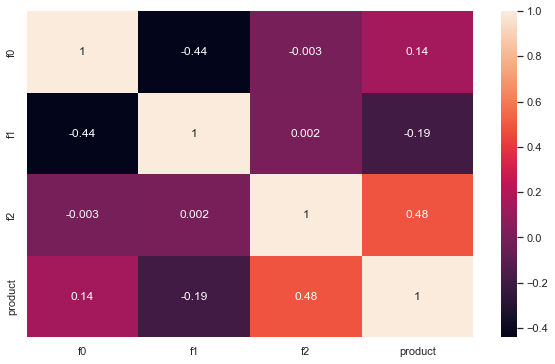

In [4]:
eda(geo_data_0)
corr_check(geo_data_0)

The data doesn't seem to require any additional preparation before we can use it
- no missing values
- data types are correct 
- no high correlations between features or features and target

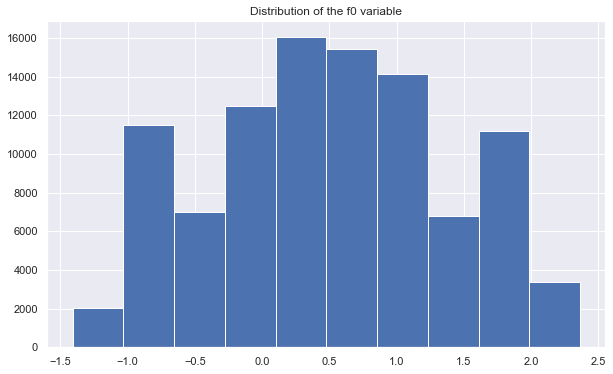

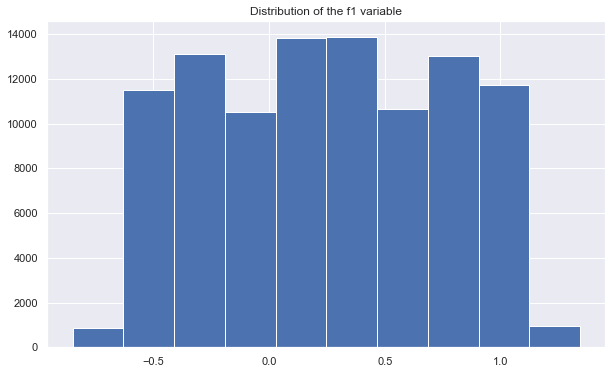

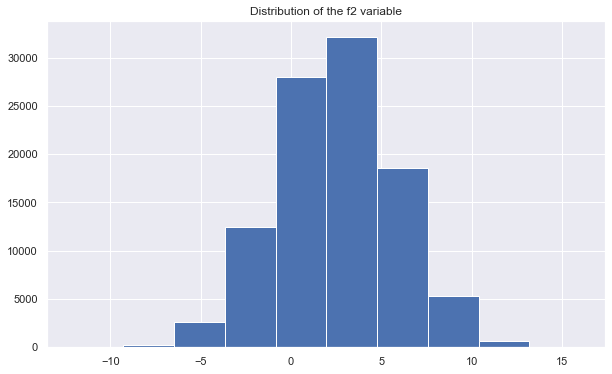

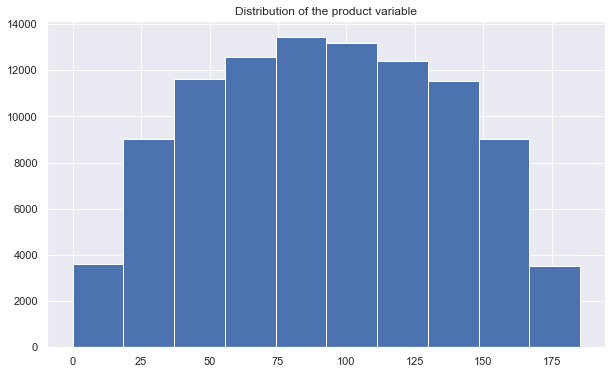

In [5]:
hist_plots(geo_data_0)

The target distribution is close to normally shaped, there are no obvious outliers.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734

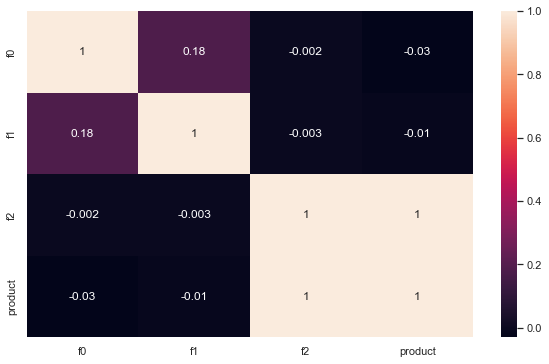

In [6]:
eda(geo_data_1)
corr_check(geo_data_1)

It is worth noting that the f2 feature has almost 100% correlation with the target variable, which may imply the target leakage. Perhaps this feature is extracted after receiving information about the amount of product in the field.

I also should inspect the data distribution of this feature and the target variable.

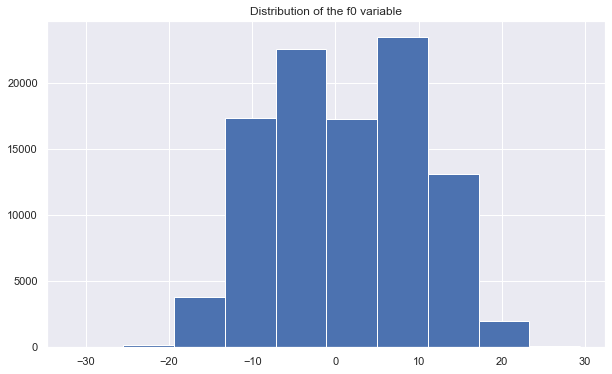

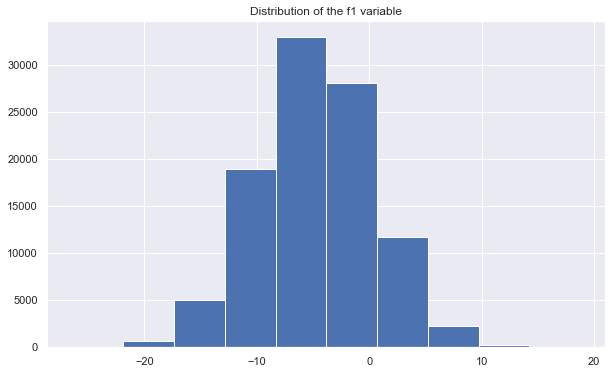

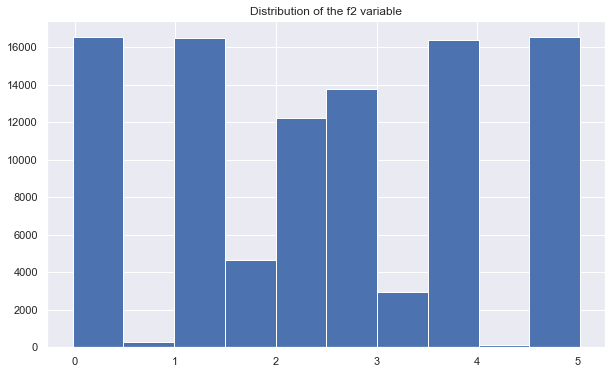

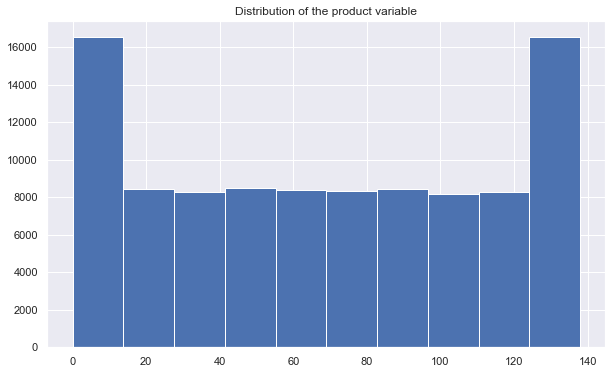

In [7]:
hist_plots(geo_data_1)

As expected the distributions of the f2 feature and the target variable are not normally distributed and the target variable has distinct bimodal distribution with peaks near min and max values.

**UPD**: After discussing this problem with the client, it was decided to carry on with this data. Since the data is synthetic the high correlation should not be considered as a problem in this project.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844

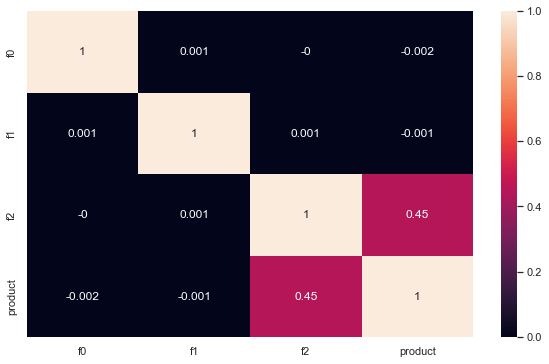

In [8]:
eda(geo_data_2)
corr_check(geo_data_2)

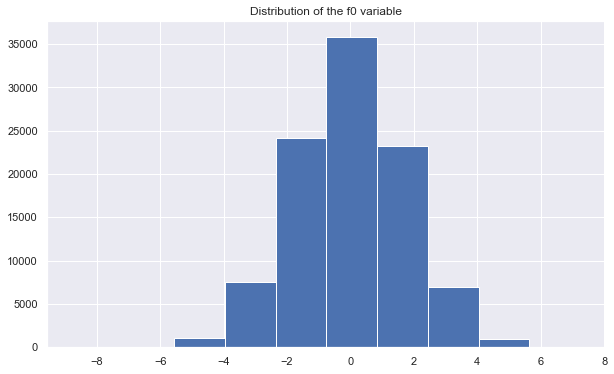

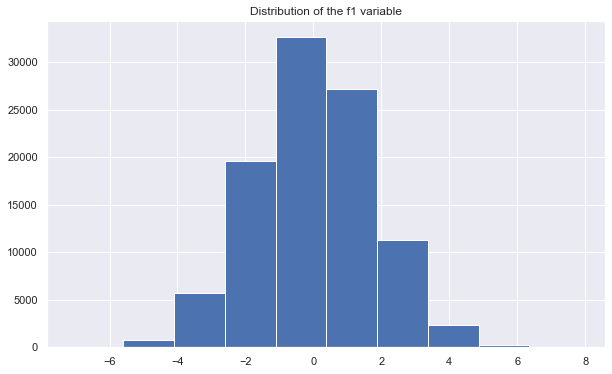

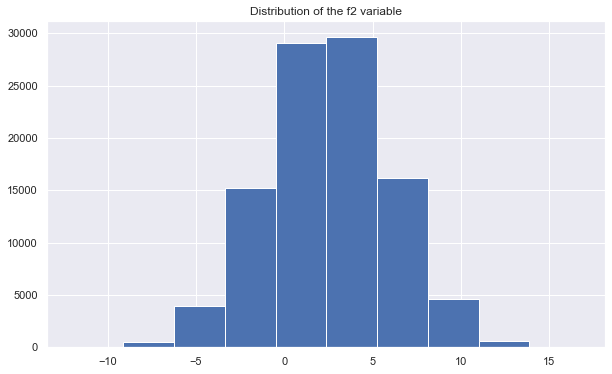

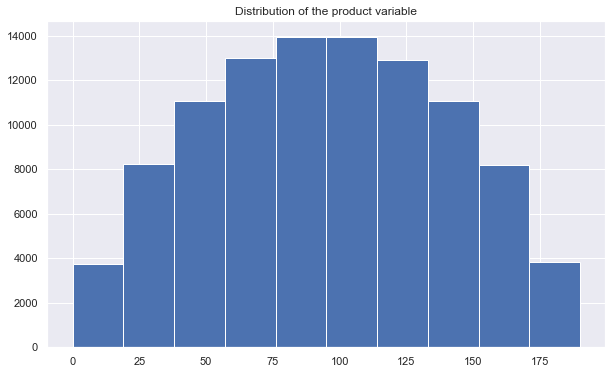

In [9]:
hist_plots(geo_data_2)

Everything seems to be all right with the third dataset. Let's move on to training the models on this data.

# Training the ML model

In [10]:
#random_state
state = 12345

In this project I use the holdout set to validate the model. This set will consist from 25% data or 25000 oil fields.

In [11]:
#splits data into 2 samples and extracts features and target for both samples
def split(data, target, test_size):
    data_train, data_test = train_test_split(data, 
                                             test_size=test_size, 
                                             random_state=state)
    X = data_train.drop(['id', target], axis=1)
    y = data_train[target]
    
    X_test = data_test.drop(['id', target], axis=1)
    y_test = data_test[target]
    
    print('Training sample size:', X.shape)
    print('Validation sample size:', y_test.shape)
    return(X, y, X_test, y_test)

In [12]:
X_0, y_0, X_valid_0, y_valid_0 = split(geo_data_0, 'product', 0.25)

Training sample size: (75000, 3)
Validation sample size: (25000,)


In [13]:
X_1, y_1, X_valid_1, y_valid_1 = split(geo_data_1, 'product', 0.25)

Training sample size: (75000, 3)
Validation sample size: (25000,)


In [14]:
X_2, y_2, X_valid_2, y_valid_2 = split(geo_data_2, 'product', 0.25)

Training sample size: (75000, 3)
Validation sample size: (25000,)


The data is ready for training and validation.

In order to compare the models performance I will use RMSE metric.\
I will also calculate the mean profit of the oil fields to compare it to the real results

In [15]:
# fit/predict + RMSE and mean_target calculation
def linear_model(X, y, X_test, y_test):
    model = LinearRegression()
    model.fit(X, y)

    predictions = model.predict(X_test)
    predictions = pd.Series(predictions, index = X_test.index)
    RMSE = round(mean_squared_error(y_test, predictions)**0.5, 2)
    mean_predicted_target = round(predictions.mean(), 2)
    mean_real_target = round(y_test.mean(), 2)

    print("Root mean squared error is", RMSE)
    print('Mean predicted target is', mean_predicted_target)
    print('Mean real target is', mean_real_target)
    return(predictions, model, RMSE, mean_predicted_target, mean_real_target)

In [16]:
predictions_0, model_0, RMSE_0, mean_predicted_target_0, mean_real_target_0 = linear_model(X_0, y_0, X_valid_0, y_valid_0)

Root mean squared error is 37.58
Mean predicted target is 92.59
Mean real target is 92.08


In [17]:
predictions_1, model_1, RMSE_1, mean_predicted_target_1, mean_real_target_1 = linear_model(X_1, y_1, X_valid_1, y_valid_1)

Root mean squared error is 0.89
Mean predicted target is 68.73
Mean real target is 68.72


In [18]:
predictions_2, model_2, RMSE_2, mean_predicted_target_2, mean_real_target_2 = linear_model(X_2, y_2, X_valid_2, y_valid_2)

Root mean squared error is 40.03
Mean predicted target is 94.97
Mean real target is 94.88


In [19]:
linear_model_results = pd.DataFrame(
    columns = ['Model_RMSE', 'Mean_predicted_product', 'Mean_real_product'],
    index = ['Region_1', 'Region_2', 'Region_3'],
    data = [[RMSE_0, mean_predicted_target_0, mean_real_target_0],
            [RMSE_1, mean_predicted_target_1, mean_real_target_1],
            [RMSE_2, mean_predicted_target_2, mean_real_target_2]])

In [20]:
linear_model_results

,Model_RMSE,Mean_predicted_product,Mean_real_product
Region_1,37.58,92.59,92.08
Region_2,0.89,68.73,68.72
Region_3,40.03,94.97,94.88


Linear regression showed similar results for the first and third regions with the RMSE equal to ~37.6 and ~40, respectively, and the mean predicted product equal to 92-94

The model trained on data from the second region gave a much smaller error, (due to the high correlation of one of the features in this sample with the target). It is also worth noting that the mean amount of oil in the second region is on average less - only ~69 thousand barrels per oil field.

Let's calculate the profits or losses that the company would have made based on the data above.

# Profit calculation

Let's define all profit calculation related variables based on the task description.

In [21]:
TOTAL_BUDGET = 10000000000 # 10 billions

PRICE_PER_BARREL = 450 # price of one barrel
PRICE_PER_PRODUCT = 450 * 1000 # one product = 1000 barrels
top = 200 # number of top predictions

In [22]:
#minimal amount of products to cover the budget
min_products = int(np.ceil(TOTAL_BUDGET / PRICE_PER_PRODUCT))
print('In order to cover the oil extraction costs, at least', min_products, 'products should be extracted.')

In order to cover the oil extraction costs, at least 22223 products should be extracted.


In [23]:
#min amount of product per object
min_mean_product = min_products / top
print('Thus, each oil field should have at least', min_mean_product, 'products')

Thus, each oil field should have at least 111.115 products


Let's compare these numbers to the average oil fields across all 3 regions

In [24]:
product_comparison = linear_model_results.copy()

product_comparison['Min_required_product'] = [111.115, 111.115, 111.115]

product_comparison

,Model_RMSE,Mean_predicted_product,Mean_real_product,Min_required_product
Region_1,37.58,92.59,92.08,111.115
Region_2,0.89,68.73,68.72,111.115
Region_3,40.03,94.97,94.88,111.115


It is easy to see that we can't just develop any oil field hoping that on average they should cover the extraction costs.

For this reason, in the next session I will select the top 200 fields based on the linear model predictions and calculate the profits and losses from their development.

# Profit and risks calculation across 200 best predicted locations

In [25]:
# calculates profit earned by the top 200 best predicted locations
# profit is defined as the price of oil in this region minus the budget
def profit_calculator(predictions, target, PRICE_PER_PRODUCT=PRICE_PER_PRODUCT, top=top):
    
    predictions_sorted = predictions.sort_values(ascending=False) #get best predictions at the top
    selected_products = target[predictions_sorted.index][:top] #get best products with the same index
    
    total_profit = (selected_products.sum()) * PRICE_PER_PRODUCT - TOTAL_BUDGET
    
    return total_profit

In [26]:
top_profit_0 = profit_calculator(predictions_0, y_valid_0)
top_profit_1 = profit_calculator(predictions_1, y_valid_1)
top_profit_2 = profit_calculator(predictions_2, y_valid_2)

In [27]:
linear_model_results['Top_200_Mean_profit'] = [top_profit_0,
                                               top_profit_1,
                                               top_profit_2]

In [28]:
linear_model_results.sort_values(by='Top_200_Mean_profit', ascending=False)

,Model_RMSE,Mean_predicted_product,Mean_real_product,Top_200_Mean_profit
Region_1,37.58,92.59,92.08,3.320826e+09
Region_3,40.03,94.97,94.88,2.710350e+09
Region_2,0.89,68.73,68.72,2.415087e+09


All three regions top 200 locations have enough oil to cover the extraction costs and make some profit.\
Highest profit could be earned in the region 1.

But before I make the conclusions, I will check the risks of not making any profit at all in these regions.

# Risks calculation

To estimate the distribution of profits in the three regions, I will apply the bootstrap technique.

I will follow this algorithm:

- Take all locations of the region
- Randomly take out a subsample of the size of 500 units from all locations. After I take a location, I shuffle it back into the dataset, so that I have a chance to take it into my subsample again.
- Using a pre-trained model, predict the amount of product in each location.
- Select the top 200 locations according to the model prediction
- Look at the real amount of product in the selected locations and calculate the profit that the company would have received if it had carried out work here
- Save the result, put it on the histogram.
- Repeat steps above 1000 times for each region.

In [29]:
state = np.random.RandomState(state)

In [30]:
def bootstrap_profit_calculator(model, X_valid, y_valid):
    values = []
    for i in range(1000):
        # bootstrap the subsample
        y_subsample = y_valid.sample(n = 500, replace=True, random_state=state)
        X_subsample = X_valid.loc[y_subsample.index]
        # predict the target
        subsample_predictions = model.predict(X_subsample)
        subsample_predictions = pd.Series(subsample_predictions, index = X_subsample.index)
        # calculate profit earned by objects with highest predicted target 
        subsample_top_profit = profit_calculator(predictions = subsample_predictions, 
                                                 target = y_subsample, 
                                                 PRICE_PER_PRODUCT=PRICE_PER_PRODUCT,
                                                 top=top)

        values.append(subsample_top_profit)
    values = pd.Series(values)
    return values

In [31]:
sns.set(rc={"figure.figsize":(10, 6)}) #width=3, #height=4

def bootstrap_profit_analysis(values, region):
    
    mean_profit = round(values.mean())
    lower = round(values.quantile(0.025))
    upper = round(values.quantile(0.975))
    risk = (values < 0).mean()
    
    sns.histplot(data=values, bins=100)
    plt.axvline(mean_profit, color='r', linestyle='--', label="Mean")
    plt.axvline(lower, color='g', linestyle=':', label="2.5% quantile")
    plt.axvline(upper, color='g', linestyle=':', label="97.5% quantile")
    plt.title('Top 200 mean profits from bootstrapped subsamples in ' + str(region), fontsize=15)
    plt.xlabel('Mean sample profit')
    plt.ylabel('Number of sample')
    plt.legend()
    plt.show()
    
    print('Mean profit is {:,}'.format(mean_profit))
    print('2.5% quantile is {:,}'.format(lower))
    print('97.5% quantile is {:,}'.format(upper))
    print('Loss risk is', "{:.1%}".format(risk))
    
    table = bootstrap_profit_risk_table.loc[region]
    table['Mean_profit'] = mean_profit
    table['97.5%_quantile'] = upper
    table['2.5%_quantile'] = lower
    table['Risk'] = "{:.1%}".format(risk)

In [32]:
values_0 = bootstrap_profit_calculator(model_0, X_valid_0, y_valid_0)

In [33]:
index = ['Region_1', 'Region_2', 'Region_3']
columns = ['Mean_profit', '2.5%_quantile', '97.5%_quantile','Risk']

bootstrap_profit_risk_table = pd.DataFrame(index = index,
                                          columns = columns)

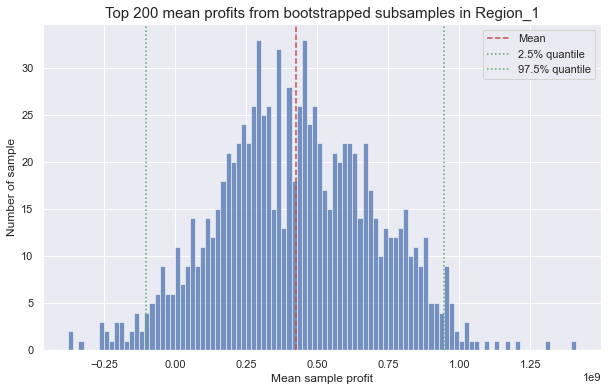

Mean profit is 425,938,527
2.5% quantile is -102,090,095
97.5% quantile is 947,976,353
Loss risk is 6.0%


In [34]:
bootstrap_profit_analysis(values_0, 'Region_1')

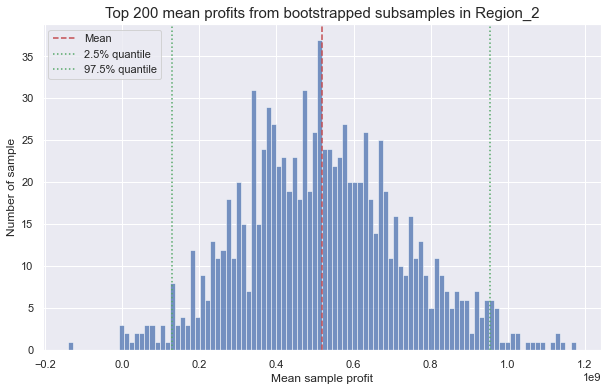

Mean profit is 518,259,494
2.5% quantile is 128,123,231
97.5% quantile is 953,612,982
Loss risk is 0.3%


In [35]:
bootstrap_profit_analysis(bootstrap_profit_calculator(model_1, X_valid_1, y_valid_1), 
                          'Region_2')

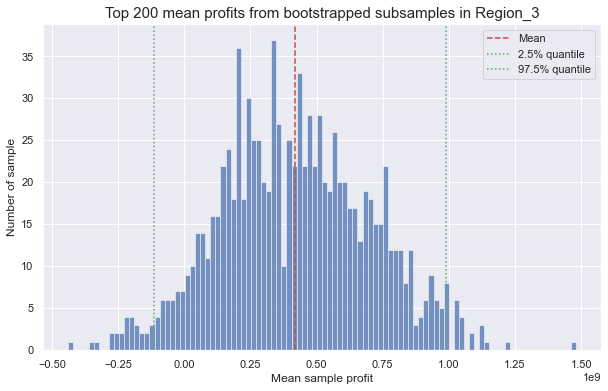

Mean profit is 420,194,005
2.5% quantile is -115,852,609
97.5% quantile is 989,629,940
Loss risk is 6.2%


In [36]:
bootstrap_profit_analysis(bootstrap_profit_calculator(model_2, X_valid_2, y_valid_2), 
                          'Region_3')

# Conclusion

The table below presents the results of the study of risk and profits in selected regions.

Only the second region can be reliably developed - the probability of losses in this region is below the set threshold of 2.5% as on the 95% confidence interval only this region gives a positive profit.\
Despite the fact that all three regions are profitable on average, the second region is not only a more reliable option, but also shows a higher average revenue.

So, my recommendation would be to develop the second region - with the least risk, locations in this region have more oil on average compared to two other regions.

In [37]:
bootstrap_profit_risk_table

,Mean_profit,2.5%_quantile,97.5%_quantile,Risk
Region_1,425938527,-102090095,947976353,6.0%
Region_2,518259494,128123231,953612982,0.3%
Region_3,420194005,-115852609,989629940,6.2%
